<a href="https://colab.research.google.com/github/seansothey/Research_Project/blob/main/Diabetic_Retinopathy_Detection_CNN(balanced_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://d2zo993x2i1w0h.cloudfront.net/live/2019/01/what-causes-diabetic-retinopathy-1024x642.jpg)

##Overview
Diabetic retinopathy is the leading cause of blindness in the working-age population of the developed world. It is estimated to affect over 93 million people.
The US Center for Disease Control and Prevention estimates that 29.1 million people in the US have diabetes and the World Health Organization estimates that 347 million people have the disease worldwide. Diabetic Retinopathy (DR) is an eye disease associated with long-standing diabetes. Around 40% to 45% of Americans with diabetes have some stage of the disease. Progression to vision impairment can be slowed or averted if DR is detected in time, however this can be difficult as the disease often shows few symptoms until it is too late to provide effective treatment.
Currently, detecting DR is a time-consuming and manual process that requires a trained clinician to examine and evaluate digital color fundus photographs of the retina. By the time human readers submit their reviews, often a day or two later, the delayed results lead to lost follow up, miscommunication, and delayed treatment.
Clinicians can identify DR by the presence of lesions associated with the vascular abnormalities caused by the disease. While this approach is effective, its resource demands are high. The expertise and equipment required are often lacking in areas where the rate of diabetes in local populations is high and DR detection is most needed. As the number of individuals with diabetes continues to grow, the infrastructure needed to prevent blindness due to DR will become even more insufficient.
The need for a comprehensive and automated method of DR screening has long been recognized, and previous efforts have made good progress using image classification, pattern recognition, and machine learning. With color fundus photography as input, the goal is to build an automated detection system to the limit of what is possible – ideally resulting in models with realistic clinical potential that can improve DR detection. This process requires many machine learning tasks and techniques to build a good classifier. To start, it is essential to obtain enough datasets, including useful information, such as number of attributes and classes.

##Datasets Description
The datasets are in image format with a large set of high-resolution retina images taken under a variety of imaging conditions. A left and right field is provided for every subject. Images are labeled with a subject id as well as either left or right (e.g. 1_left.jpeg is left eye of patient id 1).
Each image has been rated by clinicians on a scale 0 to 4 according to the presence of diabetic retinopathy.

*   0 - No DR
*   1 - Mild
*   2 - Moderate
*   3 - Severe
*   4 - Proliferative DR

The acquired images are in RGB form with high resolution JPEG format. Due to the extremely large size of this dataset, total to 82.23 GB, it was separated into archive folders. Each folder has around 8400 images, and total size about 8 GB. 
*   train.zip - the training set (5 folders)
*   test.zip - the test set (7 folders)
*   trainLabels.csv - contains the scores (0 to 4) for the training set

Dataset link: https://www.kaggle.com/c/diabetic-retinopathy-detection/data









#Setup

In [ ]:
#!pip install tensorflow-gpu

In [1]:
!nvidia-smi

Thu Oct 22 06:03:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Common Import
import sklearn
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
import os
import time
import random

import tarfile
import cv2
from google.colab.patches import cv2_imshow

# to make this notebook's output stable across runs
np.random.seed(168)

from zipfile import ZipFile

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,LabelEncoder

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore")

# sklearn version > 0.20 is required 
sklearn.__version__
# Update sklearn -> !pip install -U scikit-learn

'0.22.2.post1'

Connect to google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocessing Data

In [ ]:
!unzip "/content/drive/My Drive/new_dataset.zip"

In [6]:
DR_data = os.listdir('/content/new_dataset')

In [8]:
len(DR_data)

1243

###Create the images dataset

In [42]:
def create_img_set(imgs_folder_path):
  x=[]
  lst = os.listdir(imgs_folder_path)
  for img in lst:
    img_imr = cv2.imread(os.path.join(imgs_folder_path, img))
    img_imr = cv2.resize(img_imr,(256,256)) # resize images
    x.append(np.array(img_imr))
  return x

In [43]:
data = create_img_set(os.path.join('/content/new_dataset'))

Show some images

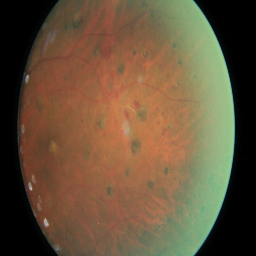

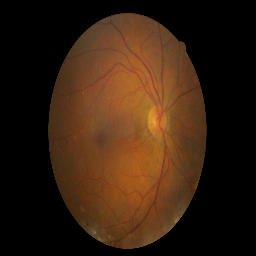

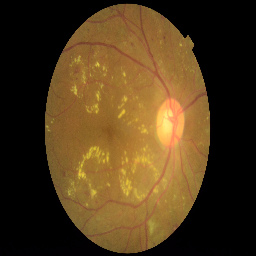

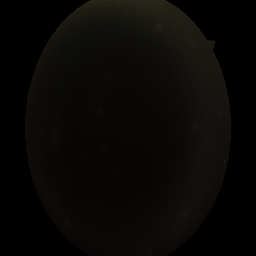

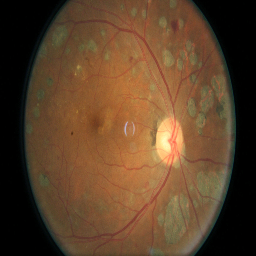

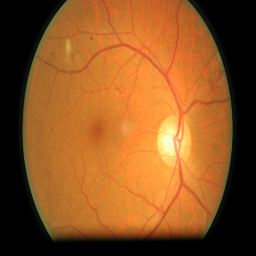

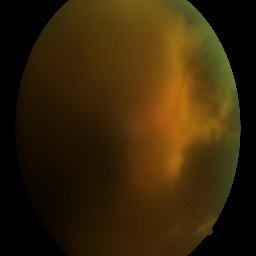

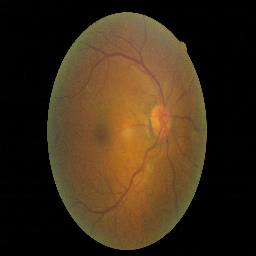

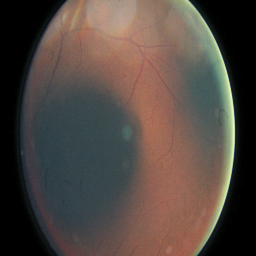

In [44]:
for i in range(0,9):
  cv2_imshow(data[i])

###Flattening the images dataset

In [45]:
data_flatten = np.array(data)

In [46]:
data_flatten.shape

(1243, 256, 256, 3)

###Scale the dataset

In [47]:
np.amax(data_flatten) # See the maximum value before scale

255

Scale to (0,1) by deviding with max. value 255

In [48]:
data_scale = data_flatten.astype('float32')/255.0

###Create label y

In [49]:
all_label = pd.read_csv("/content/trainLabels.csv")

In [50]:
all_label

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
35121,44347_right,0
35122,44348_left,0
35123,44348_right,0
35124,44349_left,0


Let's check if the classes are balanced

In [51]:
print(all_label.groupby('level').nunique())

       image
level       
0      25810
1       2443
2       5292
3        873
4        708


Because we only use subset 1427 images; therefore, we have to extract assiciated label correctly.

In [52]:
label = []

In [53]:
file_dir = os.path.join('/content/train')
files = [os.path.join(file_dir, fname) for fname in DR_data]
for fname in DR_data:
  label.append(fname.split(".")[0]) 

In [54]:
label = pd.DataFrame(label,columns=['image'])

In [55]:
label

,image
0,11492_right
1,1919_right
2,3444_right
3,1475_left
4,2970_left
...,...
1238,2767_right
1239,70_right
1240,1987_right
1241,170_left


In [56]:
new_label = pd.merge(label, all_label, on=['image'])

In [57]:
new_label

,image,level
0,11492_right,4
1,1919_right,2
2,3444_right,3
3,1475_left,2
4,2970_left,4
...,...,...
1238,2767_right,3
1239,70_right,0
1240,1987_right,2
1241,170_left,0


Check the balance of the classes

In [58]:
print(new_label.groupby('level').nunique())

       image
level       
0        249
1        244
2        250
3        250
4        250


We can see, the subset contents imbalance clasess.

Let's verify with first and last file name to see if it's matched.

In [59]:
DR_data[0], new_label['image'][0]

('11492_right.jpeg', '11492_right')

In [60]:
DR_data[500], new_label['image'][500]

('1412_left.jpeg', '1412_left')

In [61]:
DR_data[1000], new_label['image'][1000]

('104_left.jpeg', '104_left')

Therefore, the new label is created correctly and good to go!!!

In [62]:
target = new_label['level']

Split training and testing set 80:20

In [63]:
X_train, X_test, y_train, y_test = train_test_split(data_scale, target, test_size=0.2, random_state=42)

In [64]:
class_name = ['No DR','Mild','Moderate','Severe','Proliferative DR']

In [65]:
y_train_cat = to_categorical(y_train, num_classes=len(class_name))

In [66]:
y_test_cat = to_categorical(y_test, num_classes=len(class_name))

##CNN 5-layers 

In [67]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import regularizers, optimizers
import tensorflow as tf
print(tf.__version__)

np.random.seed(168)

2.3.0


Instantiate some optimizers

In [68]:
sgd = optimizers.SGD(learning_rate=0.01)
rms = optimizers.RMSprop(learning_rate=0.001, rho=0.9)
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [69]:
cnn5 = Sequential([
    Conv2D(32, kernel_size=(5, 5), activation='relu', strides=(2,2), input_shape=(256,256,3)),  # 1st layer
    MaxPooling2D(pool_size=(2, 2),strides=2),

    Conv2D(32, kernel_size=(3,3), activation='relu'), # 2nd layer
    MaxPooling2D(pool_size=(2,2), strides=2),
    BatchNormalization(),

    Conv2D(32, kernel_size=(3,3), activation='relu',  kernel_regularizer=regularizers.l2(0.01)), # 3rd layer
    MaxPooling2D(pool_size=(2,2), strides=2),
    Dropout(0.2),

    Conv2D(16, kernel_size=(3,3), activation='relu'), # 4th layer
    MaxPooling2D(pool_size=(2,2), strides=1),
    BatchNormalization(),

    Conv2D(16, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)), # 5th layer
    MaxPooling2D(pool_size=(2,2), strides=1),
    Dropout(0.2),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

In [70]:
#For Classification use 'categorical_crossentropy' or 'binary_crossentropy'
#For Regression use 'mean_square_error'
cnn5.compile(loss='categorical_crossentropy', 
              optimizer=sgd,
              metrics=['accuracy'])

In [71]:
cnn5.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 126, 126, 32)      2432      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)       

###Training the model

In [125]:
tr5 = cnn5.fit(X_train, y_train_cat, 
          batch_size=20, epochs=100, verbose=1, validation_split=0.2)

Epoch 1/100
40/40 [==============================] - 1s 15ms/step - loss: 0.9779 - accuracy: 0.6855 - val_loss: 2.2042 - val_accuracy: 0.3266
Epoch 2/100
40/40 [==============================] - 1s 13ms/step - loss: 0.9160 - accuracy: 0.7006 - val_loss: 2.4385 - val_accuracy: 0.2312
Epoch 3/100
40/40 [==============================] - 1s 14ms/step - loss: 0.9338 - accuracy: 0.6969 - val_loss: 2.3202 - val_accuracy: 0.2714
Epoch 4/100
40/40 [==============================] - 1s 14ms/step - loss: 0.8941 - accuracy: 0.7145 - val_loss: 2.2123 - val_accuracy: 0.3166
Epoch 5/100
40/40 [==============================] - 1s 14ms/step - loss: 0.8636 - accuracy: 0.7233 - val_loss: 2.3906 - val_accuracy: 0.2864
Epoch 6/100
40/40 [==============================] - 1s 14ms/step - loss: 0.8772 - accuracy: 0.7358 - val_loss: 2.4129 - val_accuracy: 0.2613
Epoch 7/100
40/40 [==============================] - 1s 14ms/step - loss: 0.9195 - accuracy: 0.6956 - val_loss: 2.6967 - val_accuracy: 0.2915
Epoch 

###See the accuracy

In [126]:
score5 = cnn5.evaluate(X_test, y_test_cat, verbose=0)
print('Test loss:', score5[0])
print('Test accuracy:', score5[1])

Test loss: 3.5663461685180664
Test accuracy: 0.2811245024204254


It's very low, let's try some more layers and augument dataset.

###See the prediction

In [127]:
pred_test = cnn5.predict_classes(X_test, verbose=0)

###Plot the learning curve

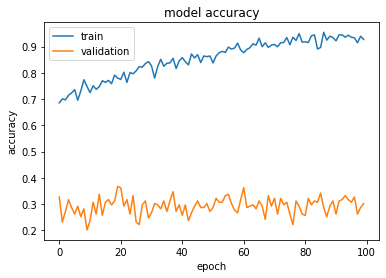

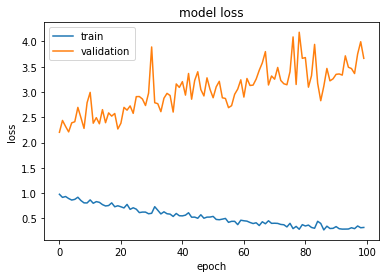

In [128]:
plt.plot(tr5.history['accuracy'])
plt.plot(tr5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(tr5.history['loss'])
plt.plot(tr5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [129]:
# Save the model as h5 file
from tensorflow.keras.models import load_model
cnn5.save('CNN5_Layers.h5')

###Classification Report

In [130]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(6)]
print(classification_report(y_test, pred_test, target_names=class_name))

                  precision    recall  f1-score   support

           No DR       0.26      0.29      0.28        52
            Mild       0.28      0.40      0.33        42
        Moderate       0.18      0.16      0.17        43
          Severe       0.25      0.22      0.24        49
Proliferative DR       0.40      0.32      0.35        63

        accuracy                           0.28       249
       macro avg       0.28      0.28      0.27       249
    weighted avg       0.28      0.28      0.28       249



###Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

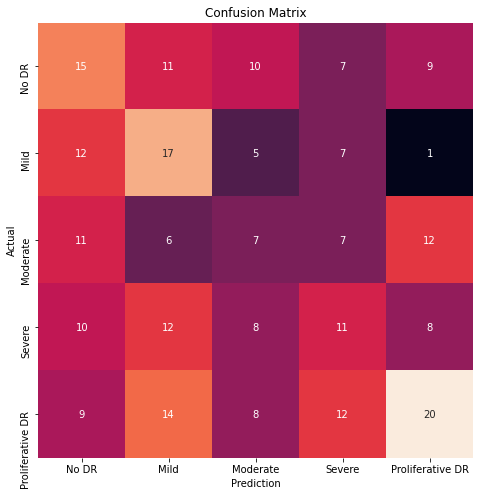

In [131]:
from sklearn.metrics import accuracy_score, confusion_matrix

fig, ax = plt.subplots(figsize=(8,8)) 
mat = confusion_matrix(pred_test, y_test)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_name,
            yticklabels=class_name)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

##Tuning hyperparameters with Keras Tuner

In [132]:
!pip install keras-tuner

In [133]:
import tensorflow as tf
import kerastuner as kt

In [134]:
def build_model(hp):
  inputs = tf.keras.Input(shape=(256, 256, 3))
  x = inputs
  for i in range(hp.Int('conv_blocks', 3, 5, default=3)):
    filters = hp.Int('filters_' + str(i), 32, 256, step=32)
    for _ in range(2):
      x = tf.keras.layers.Convolution2D(
        filters, kernel_size=(3, 3), padding='same')(x)
      x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.ReLU()(x)
    if hp.Choice('pooling_' + str(i), ['avg', 'max']) == 'max':
      x = tf.keras.layers.MaxPool2D()(x)
    else:
      x = tf.keras.layers.AvgPool2D()(x)
  x = tf.keras.layers.GlobalAvgPool2D()(x)
  x = tf.keras.layers.Dense(
      hp.Int('hidden_size', 30, 100, step=10, default=50),
      activation='relu')(x)
  x = tf.keras.layers.Dropout(
      hp.Float('dropout', 0, 0.5, step=0.1, default=0.5))(x)
  outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

  model = tf.keras.Model(inputs, outputs)
  model.compile(
    optimizer=tf.keras.optimizers.Adam(
      hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
  return model

In [135]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20, 
    executions_per_trial=2,
    directory='Hyperband',
    project_name='Diabetic_Retinopathy')

In [136]:
tuner.search(X_train, y_train_cat,
             validation_split=0.2,
             batch_size=20,
             epochs=10)

Epoch 1/3
40/40 [==============================] - 4s 105ms/step - loss: 1.6554 - accuracy: 0.2063 - val_loss: 1.6056 - val_accuracy: 0.1508
Epoch 2/3
40/40 [==============================] - 3s 81ms/step - loss: 1.6037 - accuracy: 0.2327 - val_loss: 1.6048 - val_accuracy: 0.2412
Epoch 3/3
40/40 [==============================] - 3s 79ms/step - loss: 1.5879 - accuracy: 0.2692 - val_loss: 1.6129 - val_accuracy: 0.1508
Epoch 1/3
40/40 [==============================] - 3s 86ms/step - loss: 1.6464 - accuracy: 0.2239 - val_loss: 1.6044 - val_accuracy: 0.2462
Epoch 2/3
40/40 [==============================] - 3s 79ms/step - loss: 1.5968 - accuracy: 0.2579 - val_loss: 1.6024 - val_accuracy: 0.2312
Epoch 3/3
40/40 [==============================] - 3s 79ms/step - loss: 1.5823 - accuracy: 0.2553 - val_loss: 1.6065 - val_accuracy: 0.1709


Epoch 1/3
40/40 [==============================] - 11s 277ms/step - loss: 1.6750 - accuracy: 0.1937 - val_loss: 1.6053 - val_accuracy: 0.2462
Epoch 2/3
40/40 [==============================] - 9s 231ms/step - loss: 1.6219 - accuracy: 0.2541 - val_loss: 1.6325 - val_accuracy: 0.1508
Epoch 3/3
40/40 [==============================] - 9s 232ms/step - loss: 1.6095 - accuracy: 0.2038 - val_loss: 1.6213 - val_accuracy: 0.1558
Epoch 1/3
40/40 [==============================] - 9s 237ms/step - loss: 1.6336 - accuracy: 0.2365 - val_loss: 1.6111 - val_accuracy: 0.2412
Epoch 2/3
40/40 [==============================] - 9s 234ms/step - loss: 1.6204 - accuracy: 0.2164 - val_loss: 1.6137 - val_accuracy: 0.2563
Epoch 3/3
40/40 [==============================] - 9s 232ms/step - loss: 1.6021 - accuracy: 0.2491 - val_loss: 1.6580 - val_accuracy: 0.2462


Epoch 1/3
40/40 [==============================] - 10s 245ms/step - loss: 1.6523 - accuracy: 0.1937 - val_loss: 27.6405 - val_accuracy: 0.1709
Epoch 2/3
40/40 [==============================] - 8s 204ms/step - loss: 1.6120 - accuracy: 0.1950 - val_loss: 1.9683 - val_accuracy: 0.1508
Epoch 3/3
40/40 [==============================] - 8s 202ms/step - loss: 1.6094 - accuracy: 0.2164 - val_loss: 1.6186 - val_accuracy: 0.1709
Epoch 1/3
40/40 [==============================] - 8s 210ms/step - loss: 1.7079 - accuracy: 0.1950 - val_loss: 94.1052 - val_accuracy: 0.1508
Epoch 2/3
40/40 [==============================] - 8s 203ms/step - loss: 1.6144 - accuracy: 0.2138 - val_loss: 2.8585 - val_accuracy: 0.1508
Epoch 3/3
40/40 [==============================] - 8s 206ms/step - loss: 1.6076 - accuracy: 0.2126 - val_loss: 2.0802 - val_accuracy: 0.2563


Epoch 1/3
40/40 [==============================] - 12s 307ms/step - loss: 1.6375 - accuracy: 0.2025 - val_loss: 1.8367 - val_accuracy: 0.1508
Epoch 2/3
40/40 [==============================] - 11s 266ms/step - loss: 1.6141 - accuracy: 0.1937 - val_loss: 1.7125 - val_accuracy: 0.1508
Epoch 3/3
40/40 [==============================] - 11s 268ms/step - loss: 1.6060 - accuracy: 0.2478 - val_loss: 1.6142 - val_accuracy: 0.2010
Epoch 1/3
40/40 [==============================] - 11s 275ms/step - loss: 1.6405 - accuracy: 0.2289 - val_loss: 1.6118 - val_accuracy: 0.2161
Epoch 2/3
40/40 [==============================] - 11s 268ms/step - loss: 1.6206 - accuracy: 0.1899 - val_loss: 1.6158 - val_accuracy: 0.2462
Epoch 3/3
40/40 [==============================] - 11s 265ms/step - loss: 1.6094 - accuracy: 0.2277 - val_loss: 1.6455 - val_accuracy: 0.2462


Epoch 1/3
40/40 [==============================] - 14s 350ms/step - loss: 1.8002 - accuracy: 0.2000 - val_loss: 1.6638 - val_accuracy: 0.1508
Epoch 2/3
40/40 [==============================] - 12s 307ms/step - loss: 1.6242 - accuracy: 0.2239 - val_loss: 1.7473 - val_accuracy: 0.1508
Epoch 3/3
40/40 [==============================] - 12s 308ms/step - loss: 1.6056 - accuracy: 0.2189 - val_loss: 1.7354 - val_accuracy: 0.1508
Epoch 1/3
40/40 [==============================] - 13s 314ms/step - loss: 1.7963 - accuracy: 0.1736 - val_loss: 1.6184 - val_accuracy: 0.2462
Epoch 2/3
40/40 [==============================] - 12s 307ms/step - loss: 1.6212 - accuracy: 0.2277 - val_loss: 1.6648 - val_accuracy: 0.2462
Epoch 3/3
40/40 [==============================] - 12s 307ms/step - loss: 1.6249 - accuracy: 0.2214 - val_loss: 1.6564 - val_accuracy: 0.2462


Epoch 1/3
40/40 [==============================] - 8s 205ms/step - loss: 1.7196 - accuracy: 0.1962 - val_loss: 1.6167 - val_accuracy: 0.1658
Epoch 2/3
40/40 [==============================] - 8s 191ms/step - loss: 1.6336 - accuracy: 0.2340 - val_loss: 1.6274 - val_accuracy: 0.2462
Epoch 3/3
40/40 [==============================] - 8s 188ms/step - loss: 1.6382 - accuracy: 0.2113 - val_loss: 1.6331 - val_accuracy: 0.2261
Epoch 1/3
40/40 [==============================] - 8s 194ms/step - loss: 1.7161 - accuracy: 0.2113 - val_loss: 1.6111 - val_accuracy: 0.2060
Epoch 2/3
40/40 [==============================] - 8s 189ms/step - loss: 1.6436 - accuracy: 0.2038 - val_loss: 1.6396 - val_accuracy: 0.1960
Epoch 3/3
40/40 [==============================] - 8s 189ms/step - loss: 1.6416 - accuracy: 0.2314 - val_loss: 1.6508 - val_accuracy: 0.2412


Epoch 1/3
40/40 [==============================] - 6s 139ms/step - loss: 1.7381 - accuracy: 0.2126 - val_loss: 1.6355 - val_accuracy: 0.1709
Epoch 2/3
40/40 [==============================] - 4s 112ms/step - loss: 1.6360 - accuracy: 0.1950 - val_loss: 1.6384 - val_accuracy: 0.1759
Epoch 3/3
40/40 [==============================] - 4s 112ms/step - loss: 1.6041 - accuracy: 0.2176 - val_loss: 1.6476 - val_accuracy: 0.2462
Epoch 1/3
40/40 [==============================] - 5s 116ms/step - loss: 1.7701 - accuracy: 0.2013 - val_loss: 1.6002 - val_accuracy: 0.2462
Epoch 2/3
40/40 [==============================] - 4s 110ms/step - loss: 1.6363 - accuracy: 0.2126 - val_loss: 1.6470 - val_accuracy: 0.2462
Epoch 3/3
40/40 [==============================] - 4s 110ms/step - loss: 1.6150 - accuracy: 0.1950 - val_loss: 1.7374 - val_accuracy: 0.2462


Epoch 1/3
40/40 [==============================] - 12s 292ms/step - loss: 1.6954 - accuracy: 0.2201 - val_loss: 1.6225 - val_accuracy: 0.1508
Epoch 2/3
40/40 [==============================] - 11s 278ms/step - loss: 1.6234 - accuracy: 0.2075 - val_loss: 1.6524 - val_accuracy: 0.2111
Epoch 3/3
40/40 [==============================] - 11s 276ms/step - loss: 1.6049 - accuracy: 0.2440 - val_loss: 1.7016 - val_accuracy: 0.1658
Epoch 1/3
40/40 [==============================] - 11s 282ms/step - loss: 1.7399 - accuracy: 0.1899 - val_loss: 1.6359 - val_accuracy: 0.1608
Epoch 2/3
40/40 [==============================] - 11s 276ms/step - loss: 1.6271 - accuracy: 0.2252 - val_loss: 1.6418 - val_accuracy: 0.1608
Epoch 3/3
40/40 [==============================] - 11s 279ms/step - loss: 1.6093 - accuracy: 0.2453 - val_loss: 1.7002 - val_accuracy: 0.2211


Epoch 1/3
40/40 [==============================] - 8s 198ms/step - loss: 1.6964 - accuracy: 0.1799 - val_loss: 33.8063 - val_accuracy: 0.1508
Epoch 2/3
40/40 [==============================] - 7s 184ms/step - loss: 1.6216 - accuracy: 0.2226 - val_loss: 3.2562 - val_accuracy: 0.2462
Epoch 3/3
40/40 [==============================] - 7s 182ms/step - loss: 1.6157 - accuracy: 0.1899 - val_loss: 1.6781 - val_accuracy: 0.2462
Epoch 1/3
40/40 [==============================] - 8s 189ms/step - loss: 1.7306 - accuracy: 0.1874 - val_loss: 33.5920 - val_accuracy: 0.2613
Epoch 2/3
40/40 [==============================] - 7s 181ms/step - loss: 1.6176 - accuracy: 0.2126 - val_loss: 1.6071 - val_accuracy: 0.2312
Epoch 3/3
40/40 [==============================] - 7s 181ms/step - loss: 1.6079 - accuracy: 0.2327 - val_loss: 1.8591 - val_accuracy: 0.2462


Epoch 1/3
40/40 [==============================] - 9s 219ms/step - loss: 1.6800 - accuracy: 0.1950 - val_loss: 59.1019 - val_accuracy: 0.2513
Epoch 2/3
40/40 [==============================] - 8s 203ms/step - loss: 1.6294 - accuracy: 0.1874 - val_loss: 20.1841 - val_accuracy: 0.2462
Epoch 3/3
40/40 [==============================] - 8s 203ms/step - loss: 1.6107 - accuracy: 0.2075 - val_loss: 3.4609 - val_accuracy: 0.2412
Epoch 1/3
40/40 [==============================] - 8s 209ms/step - loss: 1.7055 - accuracy: 0.2113 - val_loss: 91.9253 - val_accuracy: 0.2462
Epoch 2/3
40/40 [==============================] - 8s 203ms/step - loss: 1.6317 - accuracy: 0.2013 - val_loss: 10.2340 - val_accuracy: 0.2462
Epoch 3/3
40/40 [==============================] - 8s 203ms/step - loss: 1.6263 - accuracy: 0.2013 - val_loss: 11.8630 - val_accuracy: 0.1508


Epoch 1/3
40/40 [==============================] - 7s 182ms/step - loss: 1.6990 - accuracy: 0.2025 - val_loss: 4.6901 - val_accuracy: 0.1508
Epoch 2/3
40/40 [==============================] - 7s 169ms/step - loss: 1.6257 - accuracy: 0.2038 - val_loss: 3.3145 - val_accuracy: 0.1508
Epoch 3/3
40/40 [==============================] - 7s 169ms/step - loss: 1.6144 - accuracy: 0.2151 - val_loss: 2.0312 - val_accuracy: 0.1508
Epoch 1/3
40/40 [==============================] - 7s 177ms/step - loss: 1.6760 - accuracy: 0.1962 - val_loss: 1.6234 - val_accuracy: 0.1658
Epoch 2/3
40/40 [==============================] - 7s 170ms/step - loss: 1.6204 - accuracy: 0.2113 - val_loss: 1.6824 - val_accuracy: 0.1709
Epoch 3/3
40/40 [==============================] - 7s 168ms/step - loss: 1.6125 - accuracy: 0.2088 - val_loss: 1.6546 - val_accuracy: 0.1709


Epoch 1/3
40/40 [==============================] - 5s 131ms/step - loss: 1.6982 - accuracy: 0.1950 - val_loss: 3.6104 - val_accuracy: 0.1357
Epoch 2/3
40/40 [==============================] - 5s 113ms/step - loss: 1.6204 - accuracy: 0.2164 - val_loss: 1.6656 - val_accuracy: 0.1910
Epoch 3/3
40/40 [==============================] - 5s 113ms/step - loss: 1.6189 - accuracy: 0.2126 - val_loss: 1.6208 - val_accuracy: 0.2010
Epoch 1/3
40/40 [==============================] - 5s 117ms/step - loss: 1.6770 - accuracy: 0.1912 - val_loss: 7.3822 - val_accuracy: 0.1508
Epoch 2/3
40/40 [==============================] - 5s 114ms/step - loss: 1.6323 - accuracy: 0.2050 - val_loss: 2.0743 - val_accuracy: 0.2462
Epoch 3/3
40/40 [==============================] - 4s 111ms/step - loss: 1.6244 - accuracy: 0.2025 - val_loss: 2.8890 - val_accuracy: 0.1658


Epoch 4/7
40/40 [==============================] - 8s 188ms/step - loss: 1.7055 - accuracy: 0.2000 - val_loss: 134.6063 - val_accuracy: 0.1508
Epoch 5/7
40/40 [==============================] - 7s 184ms/step - loss: 1.6206 - accuracy: 0.2151 - val_loss: 1.7456 - val_accuracy: 0.2714
Epoch 6/7
40/40 [==============================] - 7s 181ms/step - loss: 1.6113 - accuracy: 0.2126 - val_loss: 1.6164 - val_accuracy: 0.1960
Epoch 7/7
40/40 [==============================] - 7s 181ms/step - loss: 1.6057 - accuracy: 0.2176 - val_loss: 1.6137 - val_accuracy: 0.2462
Epoch 4/7
40/40 [==============================] - 7s 187ms/step - loss: 1.6568 - accuracy: 0.1887 - val_loss: 43.9650 - val_accuracy: 0.1508
Epoch 5/7
40/40 [==============================] - 7s 181ms/step - loss: 1.6125 - accuracy: 0.2000 - val_loss: 5.7452 - val_accuracy: 0.2462
Epoch 6/7
40/40 [==============================] - 7s 180ms/step - loss: 1.6097 - accuracy: 0.2264 - val_loss: 2.3764 - val_accuracy: 0.2462
Epoch 7/7


Epoch 4/7
40/40 [==============================] - 10s 240ms/step - loss: 1.6503 - accuracy: 0.2151 - val_loss: 1.6165 - val_accuracy: 0.1709
Epoch 5/7
40/40 [==============================] - 9s 234ms/step - loss: 1.6241 - accuracy: 0.2403 - val_loss: 1.6222 - val_accuracy: 0.1759
Epoch 6/7
40/40 [==============================] - 9s 235ms/step - loss: 1.6019 - accuracy: 0.2239 - val_loss: 1.6149 - val_accuracy: 0.1910
Epoch 7/7
40/40 [==============================] - 9s 234ms/step - loss: 1.6038 - accuracy: 0.2365 - val_loss: 1.6477 - val_accuracy: 0.2111
Epoch 4/7
40/40 [==============================] - 10s 238ms/step - loss: 1.6505 - accuracy: 0.2113 - val_loss: 1.6122 - val_accuracy: 0.1508
Epoch 5/7
40/40 [==============================] - 9s 235ms/step - loss: 1.6182 - accuracy: 0.2352 - val_loss: 1.6326 - val_accuracy: 0.2462
Epoch 6/7
40/40 [==============================] - 9s 232ms/step - loss: 1.6099 - accuracy: 0.2591 - val_loss: 1.6961 - val_accuracy: 0.2462
Epoch 7/7
4

Epoch 4/7
40/40 [==============================] - 8s 212ms/step - loss: 1.6696 - accuracy: 0.2176 - val_loss: 11.7688 - val_accuracy: 0.2613
Epoch 5/7
40/40 [==============================] - 8s 203ms/step - loss: 1.6224 - accuracy: 0.1975 - val_loss: 4.8999 - val_accuracy: 0.1508
Epoch 6/7
40/40 [==============================] - 8s 203ms/step - loss: 1.6144 - accuracy: 0.2226 - val_loss: 2.0682 - val_accuracy: 0.2362
Epoch 7/7
40/40 [==============================] - 8s 203ms/step - loss: 1.6136 - accuracy: 0.2277 - val_loss: 1.7075 - val_accuracy: 0.2462
Epoch 4/7
40/40 [==============================] - 8s 210ms/step - loss: 1.7044 - accuracy: 0.2013 - val_loss: 33.0187 - val_accuracy: 0.1709
Epoch 5/7
40/40 [==============================] - 8s 203ms/step - loss: 1.6137 - accuracy: 0.2063 - val_loss: 3.9189 - val_accuracy: 0.1508
Epoch 6/7
40/40 [==============================] - 8s 203ms/step - loss: 1.6123 - accuracy: 0.2151 - val_loss: 3.4388 - val_accuracy: 0.2462
Epoch 7/7
4

Epoch 4/7
40/40 [==============================] - 5s 118ms/step - loss: 1.7662 - accuracy: 0.1862 - val_loss: 1.6111 - val_accuracy: 0.1709
Epoch 5/7
40/40 [==============================] - 4s 112ms/step - loss: 1.6154 - accuracy: 0.2314 - val_loss: 1.6279 - val_accuracy: 0.2462
Epoch 6/7
40/40 [==============================] - 4s 110ms/step - loss: 1.6080 - accuracy: 0.2415 - val_loss: 1.6494 - val_accuracy: 0.2462
Epoch 7/7
40/40 [==============================] - 4s 110ms/step - loss: 1.5990 - accuracy: 0.2201 - val_loss: 1.6277 - val_accuracy: 0.2462
Epoch 4/7
40/40 [==============================] - 5s 117ms/step - loss: 1.7134 - accuracy: 0.1962 - val_loss: 1.6410 - val_accuracy: 0.1508
Epoch 5/7
40/40 [==============================] - 4s 111ms/step - loss: 1.6445 - accuracy: 0.2314 - val_loss: 1.6500 - val_accuracy: 0.2261
Epoch 6/7
40/40 [==============================] - 4s 110ms/step - loss: 1.6284 - accuracy: 0.2075 - val_loss: 1.7034 - val_accuracy: 0.1508
Epoch 7/7
40/

Epoch 8/20
40/40 [==============================] - 8s 188ms/step - loss: 1.7125 - accuracy: 0.2101 - val_loss: 27.6522 - val_accuracy: 0.1709
Epoch 9/20
40/40 [==============================] - 7s 181ms/step - loss: 1.6107 - accuracy: 0.2289 - val_loss: 1.6115 - val_accuracy: 0.1709
Epoch 10/20
40/40 [==============================] - 7s 183ms/step - loss: 1.6121 - accuracy: 0.2201 - val_loss: 1.6147 - val_accuracy: 0.1910
Epoch 11/20
40/40 [==============================] - 7s 181ms/step - loss: 1.6063 - accuracy: 0.2302 - val_loss: 1.6211 - val_accuracy: 0.1407
Epoch 12/20
40/40 [==============================] - 7s 181ms/step - loss: 1.6030 - accuracy: 0.2201 - val_loss: 1.6427 - val_accuracy: 0.1709
Epoch 13/20
40/40 [==============================] - 7s 183ms/step - loss: 1.6040 - accuracy: 0.2314 - val_loss: 1.6311 - val_accuracy: 0.2060
Epoch 14/20
40/40 [==============================] - 7s 183ms/step - loss: 1.6057 - accuracy: 0.2038 - val_loss: 1.6393 - val_accuracy: 0.2613


Epoch 8/20
40/40 [==============================] - 8s 212ms/step - loss: 1.6935 - accuracy: 0.2000 - val_loss: 33.5450 - val_accuracy: 0.2613
Epoch 9/20
40/40 [==============================] - 8s 203ms/step - loss: 1.6178 - accuracy: 0.2189 - val_loss: 1.6232 - val_accuracy: 0.2161
Epoch 10/20
40/40 [==============================] - 8s 203ms/step - loss: 1.6146 - accuracy: 0.2075 - val_loss: 1.6572 - val_accuracy: 0.2412
Epoch 11/20
40/40 [==============================] - 8s 203ms/step - loss: 1.6248 - accuracy: 0.1975 - val_loss: 1.6440 - val_accuracy: 0.2513
Epoch 12/20
40/40 [==============================] - 8s 203ms/step - loss: 1.6171 - accuracy: 0.2138 - val_loss: 1.6298 - val_accuracy: 0.1558
Epoch 13/20
40/40 [==============================] - 8s 203ms/step - loss: 1.6134 - accuracy: 0.2050 - val_loss: 1.6268 - val_accuracy: 0.2462
Epoch 14/20
40/40 [==============================] - 8s 203ms/step - loss: 1.6081 - accuracy: 0.2088 - val_loss: 1.6460 - val_accuracy: 0.2462


Epoch 1/7
40/40 [==============================] - 7s 174ms/step - loss: 1.8014 - accuracy: 0.1862 - val_loss: 1.6146 - val_accuracy: 0.1658
Epoch 2/7
40/40 [==============================] - 7s 163ms/step - loss: 1.6307 - accuracy: 0.2239 - val_loss: 1.6309 - val_accuracy: 0.2462
Epoch 3/7
40/40 [==============================] - 6s 162ms/step - loss: 1.6191 - accuracy: 0.2403 - val_loss: 1.6398 - val_accuracy: 0.2513
Epoch 4/7
40/40 [==============================] - 6s 160ms/step - loss: 1.6111 - accuracy: 0.2113 - val_loss: 1.8289 - val_accuracy: 0.2462
Epoch 5/7
40/40 [==============================] - 6s 160ms/step - loss: 1.5987 - accuracy: 0.2516 - val_loss: 1.6245 - val_accuracy: 0.2412
Epoch 6/7
40/40 [==============================] - 6s 160ms/step - loss: 1.6133 - accuracy: 0.2214 - val_loss: 1.6836 - val_accuracy: 0.2462
Epoch 7/7
40/40 [==============================] - 6s 159ms/step - loss: 1.6001 - accuracy: 0.2214 - val_loss: 1.8016 - val_accuracy: 0.2462
Epoch 1/7
40/

Epoch 1/7
40/40 [==============================] - 6s 153ms/step - loss: 1.7261 - accuracy: 0.2025 - val_loss: 90.5462 - val_accuracy: 0.2613
Epoch 2/7
40/40 [==============================] - 6s 139ms/step - loss: 1.6157 - accuracy: 0.1836 - val_loss: 2.2850 - val_accuracy: 0.1809
Epoch 3/7
40/40 [==============================] - 6s 139ms/step - loss: 1.6116 - accuracy: 0.2075 - val_loss: 1.6062 - val_accuracy: 0.1759
Epoch 4/7
40/40 [==============================] - 6s 139ms/step - loss: 1.6086 - accuracy: 0.2189 - val_loss: 1.6495 - val_accuracy: 0.2060
Epoch 5/7
40/40 [==============================] - 6s 139ms/step - loss: 1.6068 - accuracy: 0.2189 - val_loss: 1.6219 - val_accuracy: 0.2462
Epoch 6/7
40/40 [==============================] - 6s 139ms/step - loss: 1.6084 - accuracy: 0.2151 - val_loss: 1.6238 - val_accuracy: 0.2010
Epoch 7/7
40/40 [==============================] - 6s 139ms/step - loss: 1.6036 - accuracy: 0.2151 - val_loss: 1.6510 - val_accuracy: 0.2412
Epoch 1/7
40

Epoch 1/7
40/40 [==============================] - 13s 334ms/step - loss: 1.7742 - accuracy: 0.1899 - val_loss: 4.3208 - val_accuracy: 0.1558
Epoch 2/7
40/40 [==============================] - 13s 323ms/step - loss: 1.6157 - accuracy: 0.2050 - val_loss: 1.6490 - val_accuracy: 0.2563
Epoch 3/7
40/40 [==============================] - 13s 321ms/step - loss: 1.6202 - accuracy: 0.2239 - val_loss: 1.6169 - val_accuracy: 0.2362
Epoch 4/7
40/40 [==============================] - 13s 321ms/step - loss: 1.6103 - accuracy: 0.2553 - val_loss: 1.6494 - val_accuracy: 0.1910
Epoch 5/7
40/40 [==============================] - 13s 320ms/step - loss: 1.6092 - accuracy: 0.2126 - val_loss: 1.6346 - val_accuracy: 0.1558
Epoch 6/7
40/40 [==============================] - 13s 320ms/step - loss: 1.6087 - accuracy: 0.2164 - val_loss: 1.6263 - val_accuracy: 0.1759
Epoch 7/7
40/40 [==============================] - 13s 320ms/step - loss: 1.6053 - accuracy: 0.2289 - val_loss: 1.6276 - val_accuracy: 0.2362
Epoch 

Epoch 1/7
40/40 [==============================] - 13s 318ms/step - loss: 1.6487 - accuracy: 0.2164 - val_loss: 2.3439 - val_accuracy: 0.1709
Epoch 2/7
40/40 [==============================] - 12s 308ms/step - loss: 1.6226 - accuracy: 0.2176 - val_loss: 1.9570 - val_accuracy: 0.1709
Epoch 3/7
40/40 [==============================] - 12s 311ms/step - loss: 1.6138 - accuracy: 0.2063 - val_loss: 2.0165 - val_accuracy: 0.2462
Epoch 4/7
40/40 [==============================] - 12s 309ms/step - loss: 1.6145 - accuracy: 0.2201 - val_loss: 1.9812 - val_accuracy: 0.2462
Epoch 5/7
40/40 [==============================] - 12s 308ms/step - loss: 1.6009 - accuracy: 0.2440 - val_loss: 2.3851 - val_accuracy: 0.2462
Epoch 6/7
40/40 [==============================] - 12s 308ms/step - loss: 1.6027 - accuracy: 0.2138 - val_loss: 2.2277 - val_accuracy: 0.2462
Epoch 7/7
40/40 [==============================] - 12s 308ms/step - loss: 1.6000 - accuracy: 0.2302 - val_loss: 2.1092 - val_accuracy: 0.2412
Epoch 

Epoch 1/7
40/40 [==============================] - 7s 164ms/step - loss: 1.6934 - accuracy: 0.1975 - val_loss: 3.5576 - val_accuracy: 0.1759
Epoch 2/7
40/40 [==============================] - 6s 150ms/step - loss: 1.6300 - accuracy: 0.1987 - val_loss: 1.8080 - val_accuracy: 0.1508
Epoch 3/7
40/40 [==============================] - 6s 150ms/step - loss: 1.6122 - accuracy: 0.2075 - val_loss: 1.6671 - val_accuracy: 0.1759
Epoch 4/7
40/40 [==============================] - 6s 151ms/step - loss: 1.6259 - accuracy: 0.1874 - val_loss: 1.6459 - val_accuracy: 0.2462
Epoch 5/7
40/40 [==============================] - 6s 149ms/step - loss: 1.6111 - accuracy: 0.2176 - val_loss: 1.6902 - val_accuracy: 0.2462
Epoch 6/7
40/40 [==============================] - 6s 150ms/step - loss: 1.6035 - accuracy: 0.2226 - val_loss: 1.6965 - val_accuracy: 0.2462
Epoch 7/7
40/40 [==============================] - 6s 149ms/step - loss: 1.6034 - accuracy: 0.2327 - val_loss: 1.6733 - val_accuracy: 0.2462
Epoch 1/7
40/

Epoch 1/7
40/40 [==============================] - 13s 316ms/step - loss: 1.7132 - accuracy: 0.2239 - val_loss: 1.6291 - val_accuracy: 0.2513
Epoch 2/7
40/40 [==============================] - 12s 297ms/step - loss: 1.6245 - accuracy: 0.2277 - val_loss: 1.7907 - val_accuracy: 0.2462
Epoch 3/7
40/40 [==============================] - 12s 297ms/step - loss: 1.6081 - accuracy: 0.2516 - val_loss: 1.8717 - val_accuracy: 0.2462
Epoch 4/7
40/40 [==============================] - 12s 298ms/step - loss: 1.6049 - accuracy: 0.2352 - val_loss: 1.8035 - val_accuracy: 0.2513
Epoch 5/7
40/40 [==============================] - 12s 298ms/step - loss: 1.6081 - accuracy: 0.2302 - val_loss: 1.7863 - val_accuracy: 0.2462
Epoch 6/7
40/40 [==============================] - 12s 298ms/step - loss: 1.5860 - accuracy: 0.2553 - val_loss: 1.8284 - val_accuracy: 0.2513
Epoch 7/7
40/40 [==============================] - 12s 298ms/step - loss: 1.5921 - accuracy: 0.2667 - val_loss: 1.9755 - val_accuracy: 0.2462
Epoch 

Epoch 8/20
40/40 [==============================] - 6s 147ms/step - loss: 1.7519 - accuracy: 0.1987 - val_loss: 58.2461 - val_accuracy: 0.1508
Epoch 9/20
40/40 [==============================] - 6s 141ms/step - loss: 1.6249 - accuracy: 0.2088 - val_loss: 2.4048 - val_accuracy: 0.2563
Epoch 10/20
40/40 [==============================] - 6s 138ms/step - loss: 1.6109 - accuracy: 0.2101 - val_loss: 1.6164 - val_accuracy: 0.1709
Epoch 11/20
40/40 [==============================] - 6s 139ms/step - loss: 1.6087 - accuracy: 0.2164 - val_loss: 1.6201 - val_accuracy: 0.1709
Epoch 12/20
40/40 [==============================] - 6s 139ms/step - loss: 1.6047 - accuracy: 0.2075 - val_loss: 1.6170 - val_accuracy: 0.1709
Epoch 13/20
40/40 [==============================] - 6s 139ms/step - loss: 1.6121 - accuracy: 0.2113 - val_loss: 1.6223 - val_accuracy: 0.1709
Epoch 14/20
40/40 [==============================] - 6s 138ms/step - loss: 1.6094 - accuracy: 0.2189 - val_loss: 1.6200 - val_accuracy: 0.1709


Epoch 8/20
40/40 [==============================] - 12s 304ms/step - loss: 1.6782 - accuracy: 0.2277 - val_loss: 1.6358 - val_accuracy: 0.2412
Epoch 9/20
40/40 [==============================] - 12s 298ms/step - loss: 1.6290 - accuracy: 0.2075 - val_loss: 1.7160 - val_accuracy: 0.1759
Epoch 10/20
40/40 [==============================] - 12s 299ms/step - loss: 1.6172 - accuracy: 0.2226 - val_loss: 1.6756 - val_accuracy: 0.2462
Epoch 11/20
40/40 [==============================] - 12s 298ms/step - loss: 1.6083 - accuracy: 0.2226 - val_loss: 1.7380 - val_accuracy: 0.2462
Epoch 12/20
40/40 [==============================] - 12s 298ms/step - loss: 1.6000 - accuracy: 0.2428 - val_loss: 1.8857 - val_accuracy: 0.2462
Epoch 13/20
40/40 [==============================] - 12s 298ms/step - loss: 1.5995 - accuracy: 0.2365 - val_loss: 1.8020 - val_accuracy: 0.2462
Epoch 14/20
40/40 [==============================] - 12s 297ms/step - loss: 1.5856 - accuracy: 0.2692 - val_loss: 1.8703 - val_accuracy: 0

Epoch 1/20
40/40 [==============================] - 6s 143ms/step - loss: 1.6345 - accuracy: 0.2075 - val_loss: 1.6890 - val_accuracy: 0.2111
Epoch 2/20
40/40 [==============================] - 5s 127ms/step - loss: 1.6072 - accuracy: 0.2050 - val_loss: 1.6208 - val_accuracy: 0.2663
Epoch 3/20
40/40 [==============================] - 5s 126ms/step - loss: 1.6031 - accuracy: 0.2277 - val_loss: 1.6349 - val_accuracy: 0.2412
Epoch 4/20
40/40 [==============================] - 5s 126ms/step - loss: 1.6038 - accuracy: 0.2277 - val_loss: 1.8647 - val_accuracy: 0.2462
Epoch 5/20
40/40 [==============================] - 5s 127ms/step - loss: 1.6044 - accuracy: 0.2075 - val_loss: 1.7703 - val_accuracy: 0.2312
Epoch 6/20
40/40 [==============================] - 5s 126ms/step - loss: 1.6031 - accuracy: 0.2314 - val_loss: 1.7969 - val_accuracy: 0.2462
Epoch 7/20
40/40 [==============================] - 5s 127ms/step - loss: 1.5948 - accuracy: 0.2352 - val_loss: 1.9007 - val_accuracy: 0.2362
Epoch 

Epoch 1/20
40/40 [==============================] - 11s 284ms/step - loss: 1.6829 - accuracy: 0.1887 - val_loss: 1.6411 - val_accuracy: 0.2462
Epoch 2/20
40/40 [==============================] - 11s 270ms/step - loss: 1.6141 - accuracy: 0.2390 - val_loss: 1.8378 - val_accuracy: 0.2462
Epoch 3/20
40/40 [==============================] - 11s 269ms/step - loss: 1.6012 - accuracy: 0.2642 - val_loss: 1.8485 - val_accuracy: 0.2462
Epoch 4/20
40/40 [==============================] - 11s 270ms/step - loss: 1.6056 - accuracy: 0.2314 - val_loss: 1.9447 - val_accuracy: 0.2462
Epoch 5/20
40/40 [==============================] - 11s 270ms/step - loss: 1.5980 - accuracy: 0.2478 - val_loss: 1.7621 - val_accuracy: 0.1608
Epoch 6/20
40/40 [==============================] - 11s 270ms/step - loss: 1.5980 - accuracy: 0.2541 - val_loss: 2.0644 - val_accuracy: 0.2462
Epoch 7/20
40/40 [==============================] - 11s 272ms/step - loss: 1.5859 - accuracy: 0.2604 - val_loss: 1.8865 - val_accuracy: 0.2513

Epoch 1/20
40/40 [==============================] - 9s 222ms/step - loss: 1.6694 - accuracy: 0.2063 - val_loss: 1.6385 - val_accuracy: 0.2362
Epoch 2/20
40/40 [==============================] - 9s 213ms/step - loss: 1.6028 - accuracy: 0.2327 - val_loss: 1.8442 - val_accuracy: 0.2462
Epoch 3/20
40/40 [==============================] - 8s 210ms/step - loss: 1.5989 - accuracy: 0.2302 - val_loss: 1.8137 - val_accuracy: 0.2462
Epoch 4/20
40/40 [==============================] - 8s 211ms/step - loss: 1.6024 - accuracy: 0.2314 - val_loss: 1.7369 - val_accuracy: 0.2462
Epoch 5/20
40/40 [==============================] - 8s 210ms/step - loss: 1.6036 - accuracy: 0.2478 - val_loss: 1.9215 - val_accuracy: 0.2462
Epoch 6/20
40/40 [==============================] - 8s 210ms/step - loss: 1.5967 - accuracy: 0.2428 - val_loss: 2.0254 - val_accuracy: 0.2462
Epoch 7/20
40/40 [==============================] - 8s 210ms/step - loss: 1.5955 - accuracy: 0.2465 - val_loss: 1.8754 - val_accuracy: 0.2462
Epoch 

Epoch 1/20
40/40 [==============================] - 6s 146ms/step - loss: 1.7816 - accuracy: 0.2252 - val_loss: 1.6140 - val_accuracy: 0.1709
Epoch 2/20
40/40 [==============================] - 5s 134ms/step - loss: 1.6535 - accuracy: 0.2126 - val_loss: 1.6335 - val_accuracy: 0.1508
Epoch 3/20
40/40 [==============================] - 5s 135ms/step - loss: 1.6176 - accuracy: 0.2327 - val_loss: 1.6505 - val_accuracy: 0.1508
Epoch 4/20
40/40 [==============================] - 5s 135ms/step - loss: 1.6024 - accuracy: 0.2453 - val_loss: 1.6586 - val_accuracy: 0.1508
Epoch 5/20
40/40 [==============================] - 5s 135ms/step - loss: 1.5776 - accuracy: 0.2780 - val_loss: 1.7216 - val_accuracy: 0.1508
Epoch 6/20
40/40 [==============================] - 5s 134ms/step - loss: 1.5844 - accuracy: 0.2528 - val_loss: 1.7771 - val_accuracy: 0.1508
Epoch 7/20
40/40 [==============================] - 5s 137ms/step - loss: 1.5762 - accuracy: 0.2868 - val_loss: 1.7679 - val_accuracy: 0.2412
Epoch 

INFO:tensorflow:Oracle triggered exit


In [137]:
model = tuner.get_best_models(num_models=1)[0]

In [138]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 64)      256       
_________________________________________________________________
re_lu (ReLU)                 (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 256, 256, 64)     

In [139]:
model.fit(X_train, y_train_cat, epochs=10, validation_split=0.2)

Epoch 1/10
25/25 [==============================] - 5s 208ms/step - loss: 1.5899 - accuracy: 0.2340 - val_loss: 1.7474 - val_accuracy: 0.2462
Epoch 2/10
25/25 [==============================] - 5s 183ms/step - loss: 1.5842 - accuracy: 0.2440 - val_loss: 1.7032 - val_accuracy: 0.2161
Epoch 3/10
25/25 [==============================] - 5s 183ms/step - loss: 1.5807 - accuracy: 0.2541 - val_loss: 1.7568 - val_accuracy: 0.2211
Epoch 4/10
25/25 [==============================] - 5s 184ms/step - loss: 1.5763 - accuracy: 0.2528 - val_loss: 1.7402 - val_accuracy: 0.2010
Epoch 5/10
25/25 [==============================] - 5s 183ms/step - loss: 1.5764 - accuracy: 0.2616 - val_loss: 1.6832 - val_accuracy: 0.2462
Epoch 6/10
25/25 [==============================] - 5s 183ms/step - loss: 1.5753 - accuracy: 0.2516 - val_loss: 1.7774 - val_accuracy: 0.2010
Epoch 7/10
25/25 [==============================] - 5s 183ms/step - loss: 1.5689 - accuracy: 0.2654 - val_loss: 1.6640 - val_accuracy: 0.2462
Epoch 

In [140]:
score = model.evaluate(X_test, y_test_cat, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.7291719913482666
Test accuracy: 0.23694778978824615


In [141]:
pred_tuner = model.predict(X_test, verbose=0)

In [142]:
pred_tuner = np.argmax(pred_tuner,axis=1)

In [143]:
print(classification_report(y_test, pred_tuner, target_names=class_name))

                  precision    recall  f1-score   support

           No DR       0.14      0.06      0.08        52
            Mild       0.13      0.05      0.07        42
        Moderate       0.00      0.00      0.00        43
          Severe       0.19      0.18      0.19        49
Proliferative DR       0.27      0.71      0.39        63

        accuracy                           0.24       249
       macro avg       0.15      0.20      0.15       249
    weighted avg       0.16      0.24      0.17       249



Text(0.5, 1.0, 'Confusion Matrix')

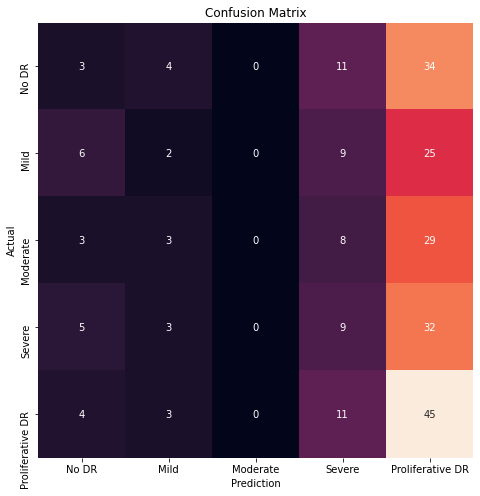

In [144]:
fig, ax = plt.subplots(figsize=(8,8)) 
mat = confusion_matrix(pred_tuner, y_test)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_name,
            yticklabels=class_name)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

In [145]:
#Save the model
tuner_model = Sequential(layers=model.layers)
tuner_model.save('CNN5_Tuner.h5')